# Marine Heatwaves 2
# Driving mechanisms: 2011 Leeuwin Current Marine Heatwave and El Niño–Southern Oscillation

This notebook examines the 2011 Leeuwin Current Marine Heatwave (MHW) off the coast of Western Australia and the driving role of the 2010–2011 La Niña. La Niña is the negative phase of the El Niño–Southern Oscillation (ENSO) climate cycle, where warm surface waters pile up in the western Pacific and to the north of Australia. 


This notebook examines global satellite sea surface temperature (SST) from the  NOAA  Optimum  Interpolation  Sea  Surface Temperature (OISST) dataset. The Marine Heatwave (MHW) definition of Hobday et al. (found here: https://tos.org/oceanography/assets/docs/31-2_hobday.pdf) is implemented using the the marineHeatWaves module as outlined here: https://github.com/ecjoliver/marineHeatWaves/blob/master/docs/example_synthetic.ipynb.

For more information on the OISST dataset:
https://www.ncdc.noaa.gov/oisst


The files can be found at: 
https://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/noaa.oisst.v2.highres/catalog.html

El Niño (La Niña) is a phenomenon in the equatorial Pacific Ocean characterized by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region that is above (below) the threshold of +0.5°C (-0.5°C). This standard of measure is known as the Oceanic Niño Index (ONI).

In [39]:
# Load required modules (ignore the yaml warning).
import numpy as np
import xarray as xr
import pandas as pd
import time
import yaml
import scipy.stats as stats
from datetime import date, timedelta
from matplotlib import pyplot as plt
from io import StringIO
import requests
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [71]:
# Add the latitude and longitude of the data that you downloaded from the MHW tracker (must be exactly the same!).
lat = -28.875
lon = 112.875

# Select year range (can be from 1981 to 2019, but less than 30 years).
# TODO: Add in month range
start = date(2010, 10, 1)
end = date(2011, 10, 1)

Load in the csv files you downloaded from the MHW tracker site (depends on the lat/lon values entered above).

In [72]:
clim = pd.read_csv('clim_lon_{}_lat_{}.csv'.format(lon, lat))
mhws = pd.read_csv('event_lon_{}_lat_{}.csv'.format(lon, lat), parse_dates=[4, 5, 6])

In [69]:
url ='http://www.bom.gov.au/climate/enso/soi_monthly.txt'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) ' + 
           'Chrome/56.0.2924.76 Safari/537.36'}

s = requests.get(url, headers= headers).text

soi = pd.read_csv(StringIO(s), sep=",", names=['time', 'soi'])
soi['time'] = pd.to_datetime(soi['time'], format='%Y%m', errors='coerce').dropna() # convert time column to dates
soi.head()

,time,soi
0,1876-01-01,11.3
1,1876-02-01,11.0
2,1876-03-01,0.2
3,1876-04-01,9.4
4,1876-05-01,6.8


In [66]:
http://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt
    https://www.esrl.noaa.gov/psd/data/correlation/nina34.data
        https://www.esrl.noaa.gov/psd/data/correlation/nina34.data

Timestamp('1876-01-01 00:00:00')

(734046.0, 734411.0)

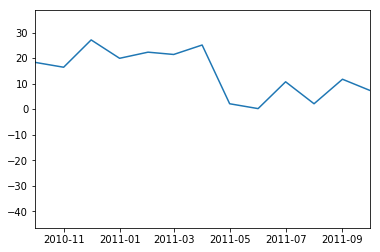

In [67]:
plt.plot(soi.time, soi.soi)
plt.xlim([start, end])

Open the SST satellite data as an xarray dataset (this may be slow depending on the year range):

In [73]:
# URL of NOAA OISST daily anomaly data (SST minus climatology). 
# Note that we're not loading the mean daily SST like the first notebook.
url_anom = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.anom'

# Create a list of NOAA URLs in the year range.
files_anom = [f'{url_anom}.{year}.v2.nc' for year in range(start.year, end.year + 1)]

# Open files as an xarray dataset (this may take a couple of minutes).
ds = xr.open_mfdataset(files_anom)
ds

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 730)
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * time     (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2011-12-31
Data variables:
    anom     (time, lat, lon) float32 dask.array<shape=(730, 720, 1440), chunksize=(365, 720, 1440)>
Attributes:
    Conventions:                     CF-1.5
    title:                           NOAA High-resolution Blended Analysis: D...
    institution:                     NOAA/NCDC
    source:                          NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/p...
    comment:                         Reynolds, et al., 2007: Daily High-Resol...
    history:                         Thu Jan 18 09:42:39 2018: ncatted -O -a ...
    references:                      https://www.esrl.noaa.gov/psd/data/gridd...
    dataset_title:                   NOAA Daily Optimum Interpolation Se

In [ ]:
# # URL of NOAA OISST daily mean and daily anomaly data.
# url_sst = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean'
# url_anom = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.anom'

# # Create a list of NOAA URLs in the year range.
# files_sst = [f'{url_sst}.{year}.v2.nc' for year in range(year_start, year_end + 1)]
# files_anom = [f'{url_anom}.{year}.v2.nc' for year in range(year_start, year_end + 1)]

# # Open files as an xarray dataset (this may take a couple of minutes).
# # ds = xr.open_mfdataset([files_sst, files_anom])
# ds = xr.open_mfdataset(files_anom)
# # ds = ds.sel(time=slice('2010-10', '2011-06')) # Reduce the time values to load.
# ds

## Calculate the nino3.4 index:

In [81]:
start = time.time()
# Calculate the nino3.4 index averaged over the nino3.4 area (don't change the latitude and longitudes!).
sst_anom_nino34 = ds.anom.sel(lat=slice(-5, 5), lon=slice(190, 240)).mean(['lon', 'lat'])

oni = sst_anom_nino34.rolling(time=3).mean(dim='time')

print('Execution time:', str(timedelta(seconds=time.time() - start)))

Execution time: 0:00:00.003989


In [84]:
sst_anom_nino34 = sst_anom_nino34.values
oni = oni.values

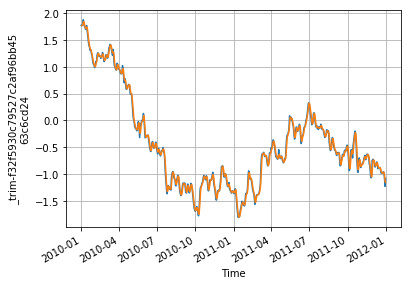

In [83]:
fig, ax = plt.subplots()
sst_anom_nino34.plot(ax=ax, label='raw')
oni.plot(ax=ax, label='smoothed')
ax.grid()

Calculate the MHW event of the Leeuwin Current:

In [7]:
start = time.time()
# sst_lc = ds.sst.sel(lat=lat, lon=lon, method='nearest')
sst_anom_lc = ds.anom.sel(lat=lat, lon=lon, method='nearest').values
print('Execution time:', str(timedelta(seconds=time.time() - start)))

Execution time: 0:00:00.001994


In [8]:
# sst_anom_lc = ds.anom.sel(lat=slice(-32, -26), lon=slice(112, 115)).mean(['lat', 'lon'])

In [9]:
# # Calculate the SST climatology (month-to-month mean). Takes ~3 mins.
# lc_clim = dl.groupby('time.month').mean('time')
# print('Execution time:', str(timedelta(seconds=time.time() - start)))

# # Calculate the SST anomaly (SST minus climatology). Takes ~3 mins.
# lc_anom = dl.groupby('time.month') - lc_clim
# print('Execution time:', str(timedelta(seconds=time.time() - start)))

In [75]:
t = pd.to_datetime(ds.time.values) # Time series of the satellite SST data.
# Creating a loop of the SST long-term mean seasonal and MHW thredhold values (for time series longer than a year).
days = [] # Finding the number of days in each year (in case there is a leap year).
[days.append((date(y + 1, 1, 1) - date(y, 1, 1)).days) for y in range(year_start, year_end + 1)]
thresh = clim.thresh
seas = clim.seas
for i in range(year_end - year_start):
    thresh = np.append(thresh[:days[i]], thresh[:days[i + 1]], 0)
    seas = np.append(seas[:days[i]], seas[:days[i + 1]], 0)
    
thresh_anom = thresh - seas

In [76]:
ev = mhws.intensity_max.idxmax() # Finds the index of the largest event.

## Plot a timeseries of the Nino 3.4 SST anomalies and Leeuwin Current SST:

Execution time: 0:00:00.033910
Execution time: 0:02:05.415751


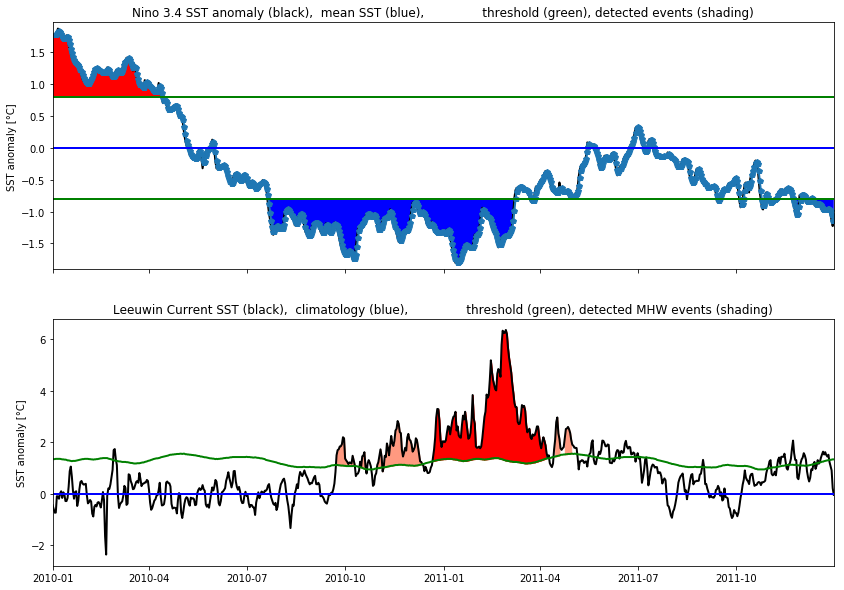

In [85]:
start = time.time()
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10), sharex=True)

# Subplot 1: Nino 3.4 anomalies.
ax1.set_title('Nino 3.4 SST anomaly (black),  mean SST (blue), \
              threshold (green), detected events (shading)')
bnd1 = 0.8 # Bound of Nino 3.4 threshold (in °C).
bnd2 = -bnd1 # Lower bound of Nino 3.4 threshold (in °C).
# Plot the Nino 3.4 SST anomaly as a black line.
ax1.plot(t, sst_anom_nino34, 'k-', linewidth=2)
ax1.plot(t, oni, 'p-', linewidth=2)
# Plots a blue line at 0°C (climatology).
ax1.axhline(y=0, color='b', linewidth=2)
# Plot a green line at the upper and lower bounds.
ax1.axhline(y=bnd1, color='g', linewidth=2) 
ax1.axhline(y=bnd2, color='g', linewidth=2)
# Shades the SST anomaly red (blue) if greater (lower) than the bounds.
ax1.fill_between(t, bnd1, sst_anom_nino34, where=sst_anom_nino34 > bnd1, facecolor='red') # Red for El Nino.
ax1.fill_between(t, bnd2, sst_anom_nino34, where=sst_anom_nino34 < bnd2, facecolor='blue') # Blue for La Nina.
# Label the y-axis.
ax1.set_ylabel('SST anomaly [°C]')
# Set the maximum and minimum SST anomaly range.
ax1.set_ylim(sst_anom_nino34.min() - 0.1, sst_anom_nino34.max() + 0.1)
# Restrict the x-axis to the data's time series (sharing x-axis, so works for both plots).
ax1.set_xlim(t[0], t[-1]) 
print('Execution time:', str(timedelta(seconds=time.time() - start)))

# Subplot 2: Leeuwin Current SST.
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
ax2.set_title('Leeuwin Current SST (black),  climatology (blue), \
              threshold (green), detected MHW events (shading)')
ax2.plot(t, sst_anom_lc, 'k-', linewidth=2)
ax2.plot(t, thresh_anom, 'g-', linewidth=2)
# Plots a blue line at 0°C (climatology).
ax2.axhline(y=0, color='b', linewidth=2)
# Find indices for closest MHW before and after event of interest and shade accordingly.
for ev0 in np.arange(ev - 3, ev + 3, 1):
    t1 = np.where(t == mhws.date_start[ev0])[0][0]
    t2 = np.where(t == mhws.date_end[ev0])[0][0]
    plt.fill_between(t[t1:t2 + 1], sst_anom_lc[t1:t2 + 1], thresh_anom[t1:t2 + 1], color=(1, 0.6, 0.5))

# Find indices for MHW start and end date of interest and shade accordingly
t1 = np.where(t == mhws.date_start[ev])[0][0]
t2 = np.where(t == mhws.date_end[ev])[0][0]
plt.fill_between(t[t1:t2 + 1], sst_anom_lc[t1:t2 + 1], thresh_anom[t1:t2 + 1], color='r')
# plt.ylim(seas.min() - 1, seas.max() + mhws.intensity_max[ev] + 0.5)
plt.ylabel('SST anomaly [°C]')
print('Execution time:', str(timedelta(seconds=time.time() - start)))
plt.savefig('Nino34_Leeuwin_Current_lon_{}_lat_{}.png'.format(lon, lat)) # Save the figure to your computer.

In [ ]:
# Might need later.
start = time.time() # Records the time now (to get total computation time later).
print('Execution time:', str(timedelta(seconds=time.time() - start))) # Format is hours:minutes:seconds